In [1]:
import os, sys

# go up one directory into the "SSD" directory
os.chdir("..")

# make sure you're in the "SSD" directory
os.getcwd()

'/home/wlyeow/tdt4265/TDT4265_StarterCode/assignment4/SSD'

In [2]:
import matplotlib.pyplot as plt
from analyze_stuff import analyze_something, get_dataloader, get_config
from save_images_with_annotations import save_images_with_annotations
import torch
from tqdm import tqdm
import numpy as np
from collections import Counter
from ssd.modeling.anchor_encoder import calc_iou_tensor

In [3]:
config_path = "configs/tdt4265.py"
cfg = get_config(config_path)
dataset_to_analyze = "train"  # or "val"

dataloader = get_dataloader(cfg, dataset_to_analyze)
data = analyze_something(dataloader, cfg)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


NOTE! Installing ujson may make loading annotations faster.
It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/wlyeow
	If you struggle with NTNU home directory becoming full, we recommend you to change the output directory to: /work/snotra/wlyeow
	 /work/snotra/wlyeow does not sync with NTNU HOME, and is a directory only located on the server.
	 To change the output directory of SSD, set save_in_work to True in the file configs/utils.py, in the function get_output_dir.
Saving SSD outputs to: outputs/
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


100%|████████████████████████████████████████████| 1604/1604 [00:20<00:00, 78.72it/s]


In [4]:
print("Label map is:", cfg.label_map)

Label map is: {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}


Counter({'car': 9563, 'person': 4910, 'rider': 1588, 'bicycle': 1043, 'scooter': 615, 'bus': 445, 'truck': 123})


<BarContainer object of 7 artists>

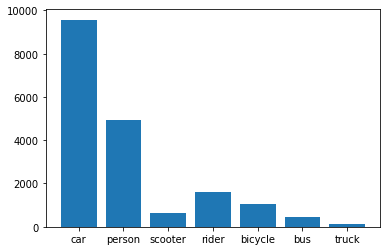

In [5]:
label_counts = data["label_counts"]
labels = []
counts = []
for k, v in label_counts.items():
    labels.append(cfg.label_map[k.item()])
#     counts.append(v)

counter = Counter(labels)
print(counter)

# plt.bar(labels, counts)
plt.bar(counter.keys(), counter.values())

Overall, the distribution of classes seems to largely be correct as to what I have seen for myself in Trondheim. As this dataset is taken from a car, it is likely that it would be driving nearer to cars and hence less people. 

There may be an issue as within the train dataset, there are no motorcycles for the model to train on.

Interestingly, there is a mismatch between rider and bicycle + motorcycle numbers where the number of bicycles is less than the number of riders and we have 0 bicycles. We understand that a rider is represented as a collection of a rider and a bicycle/motorcycle. This may be due to occlusion of the vehicle, but since the difference is very high



Our initial guess before this visualization would be there would be more bicycles as we could have bicycles without riders (just lying by the road), but a rider would need to have a bicycle, else he would be a person. This could require more visualization into cases where we have a rider and not a bicycle.

In [6]:
from dataset_exploration.plot_img_with_bbox import visualize_img, visualize_img_no_box

In [7]:
def unpack_batch(batch, cfg):
    
    image = batch["image"].clone()
    boxes = batch["boxes"].clone()
    
    image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
    image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)
    
    im = image.clone()
    im = (im * image_std + image_mean)
    im = (im * 255).byte()
    im = im[0]
    box = boxes[0].clone()
    box[:, [0,2]] *= im.shape[-1]
    box[:, [1,3]] *= im.shape[-2]
    
    
    batch_new = batch.copy()
    batch_new["image"] = im
    batch_new["boxes"] = box
    return batch_new

In [8]:
def get_label_from_tensor(tensor, cfg):
    flat_tensor = tensor[0] if tensor.ndim > 1 else tensor
    arr = flat_tensor.numpy()
    return [cfg.label_map[int(x)] for x in arr]

  0%|                                                       | 0/1604 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|                                                       | 0/1604 [00:00<?, ?it/s]


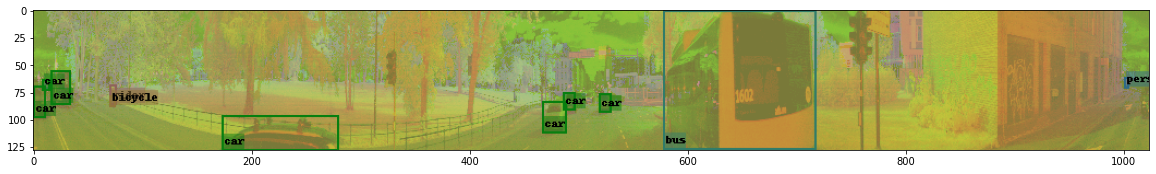

In [9]:
for batch in tqdm(dataloader):
    labels = get_label_from_tensor(batch["labels"], cfg)
    if "rider" in labels and "bicycle" in labels:
        break
        
_ = visualize_img(batch["image"], batch["boxes"], batch["labels"], cfg, to_print=True, to_save=False)

The following are helper functions to help us filter out riders and vehicles from a batch, filter out riders and vehicles that do not have any IOUs with a vehicle or rider respectively, and a wrapper around it for visualizations.

Our filtering criterions are the following:
1. Isolate all labels of ```rider```, ```bicycle``` and ```scooter```.
2. We then calculate the IOU values of all rider bbox and all (bicycle and scooter) bboxes. We take the maximum IOU value for each rider class and filter any class below the IOU minimum of 0.005.

We treat all instances where there are riders but no bicycle or scooters as an instance of interest and isolate it. This is through our use of a minimum IOU of 0.005. We have dived into the data and saw that there are instances where the bicycle is labelled but the rider is not. However, there are much more cases where the bicycle is just parked at the side of the road. Hence to simplify visualizations, we will not be filtering those cases out.

In [10]:
def filter_for_rider_vehicle(batch):
    set_of_idx = []
    rider_idx = []
    bicycle_idx = []
    scooter_idx = []
    
    label_mapper = {
        "rider": rider_idx,
        "bicycle": bicycle_idx,
        "scooter": scooter_idx
             }

    idx = 0
    for i, label in enumerate(get_label_from_tensor(batch["labels"], cfg)):
        if label == "rider" or label == "bicycle" or label == "scooter":
            set_of_idx.append(i)
            label_mapper[label].append(idx)

            idx += 1

    rider_idx = np.array(rider_idx)
    bicycle_idx = np.array(bicycle_idx)
    scooter_idx = np.array(scooter_idx)
    
    vehicles_idx = np.append(bicycle_idx, scooter_idx).astype('int64')
    
    return set_of_idx, rider_idx, vehicles_idx

def get_isolated_riders_idx(filtered_boxes, rider_idx, vehicles_idx, iou_minimum=0.005, print_ious=False):
    rider_boxes = filtered_boxes[:, rider_idx][0]
    vehicle_boxes = filtered_boxes[:, vehicles_idx][0]
#     scooter_boxes = filtered_boxes[:, scooter_idx]

    iou_calcs = calc_iou_tensor(rider_boxes, vehicle_boxes)
    
    # Understandably, in a small area, some riders and bicycles may be congested. It would be hard even for a human to discern them.
    # Hence we would take the maximum IOU that each rider has. All riders below a minimum value would be tagged as "isolated"
    isolated_idx = np.where(iou_calcs.max(1).values.numpy() < iou_minimum)[0]
    if print_ious and len(isolated_idx) > 0:
        print(iou_calcs)
    return rider_idx[isolated_idx]
    

def get_rider_vehicle_mismatch(batch, to_print=False, to_save=True, save_dir=None):
    rider_vehicle_idx, rider_idx, vehicle_idx = filter_for_rider_vehicle(batch)
    
    # I know that there are some instances where a bicycle is labelled but not a rider. 
    # However, there are much more instances where there are only bicycles parked at the side of a road.
    # Hence, we will not be considering this case where there are no riders to ease visualization.
    if len(rider_idx) == 0:
        return None
    
    filtered_boxes = batch["boxes"][:, rider_vehicle_idx]
    filtered_labels = batch["labels"][:, rider_vehicle_idx]
    
    vehicles_present = len(vehicle_idx) > 0
    
    if vehicles_present:
        isolated_rider_idx = get_isolated_riders_idx(filtered_boxes, rider_idx, vehicle_idx)
        if len(isolated_rider_idx) == 0:
            return None
        
    isolated_boxes = filtered_boxes[:, isolated_rider_idx] if vehicles_present else filtered_boxes
    isolated_labels = filtered_labels[:, isolated_rider_idx] if vehicles_present else filtered_labels
        
    return visualize_img(batch["image"], isolated_boxes, isolated_labels, cfg, to_print=to_print, to_save=to_save, save_dir=save_dir), batch["image_id"].item()
        

In [11]:
_ = get_rider_vehicle_mismatch(batch, to_print=True, to_save=False)

We observe that this is an example of a rider without a bicycle. To confirm our filtering is correct, we also print all the boxes of the image as well as no boxes of the image. 

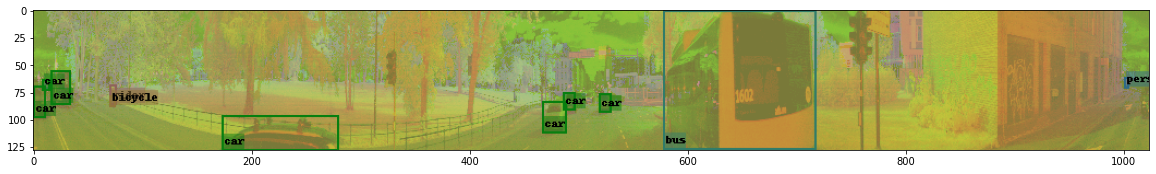

In [12]:
_ = visualize_img(batch["image"], batch["boxes"], batch["labels"], cfg, to_print=True, to_save=False)

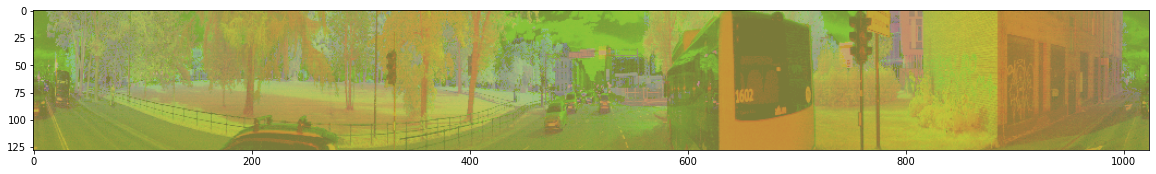

In [13]:
_ = visualize_img_no_box(batch["image"], cfg, to_print=True)

With just a random example, we can already observe the issues where these riders do not have their bicycles labelled. This does not look like there is much difficulty in determining that it is a bicycle as compared to a scooter. Hence is an example of wrong labelling.

In [14]:
save_dir = os.path.join(os.getcwd(), "dataset_exploration/visualizations")

In [15]:
files = [y for x in os.walk(save_dir) for y in x[2]]
curr_idx = len(files)

file_name = f"visualization_{curr_idx:04d}.png"
print(file_name)

visualization_0000.png


We will define a helper function to extract height, width and class of an image from a batch. We are using COCO format of [xmin, ymin, xmax, ymax]. This would return the width and height of all in the batch.

In [16]:
def get_aspect_ratio_class(batch):
    batch = unpack_batch(batch, cfg)
    boxes = batch["boxes"].numpy()
    aspect_ratio = np.array(list(map(lambda x: (x[2] - x[0], x[3] - x[1]), boxes)))
    labels = batch["labels"].numpy()[0]
    return np.append(aspect_ratio, labels.reshape(-1, 1), axis=1)

In [17]:
vizs = []
arcs = None

sys.path.append(os.path.dirname(os.getcwd()))
save_dir = os.path.join(os.getcwd(), "dataset_exploration/visualizations/")
print(f"Saving to default dir: {save_dir}")


for batch in tqdm(dataloader):
    labels = get_label_from_tensor(batch["labels"], cfg)
    if "rider" in labels and ("bicycle" in labels or "scooter" in labels):
        viz = get_rider_vehicle_mismatch(batch, save_dir=save_dir)
        if viz is not None:
            vizs.append((viz, batch))
            
    aspect_ratio_class = get_aspect_ratio_class(batch)
    if aspect_ratio_class.ndim > 0:
        arcs = aspect_ratio_class if arcs is None else np.append(arcs, aspect_ratio_class, axis=0)

Saving to default dir: /home/wlyeow/tdt4265/TDT4265_StarterCode/assignment4/SSD/dataset_exploration/visualizations/


100%|████████████████████████████████████████████| 1604/1604 [00:52<00:00, 30.60it/s]


In [18]:
from PIL import Image
import pickle

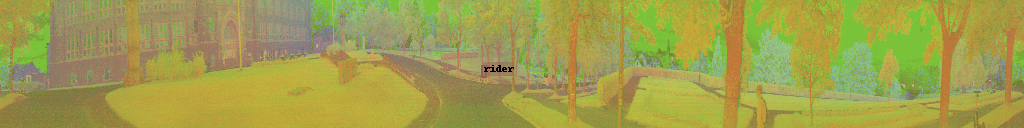

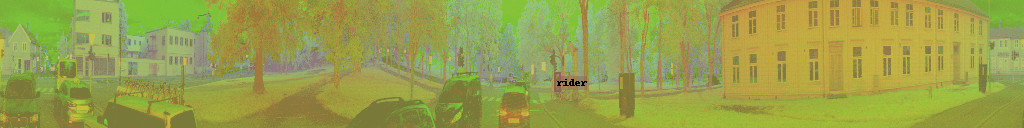

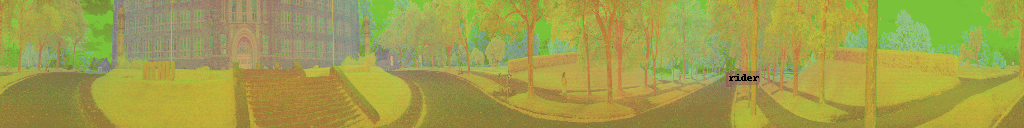

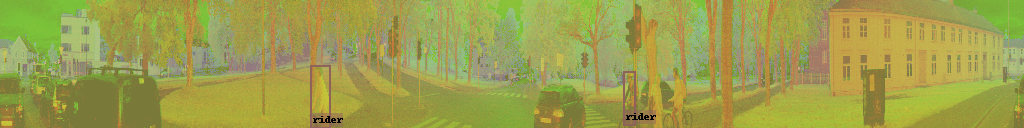

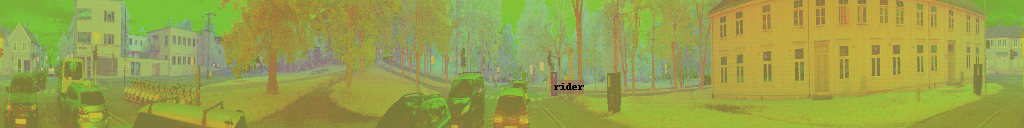

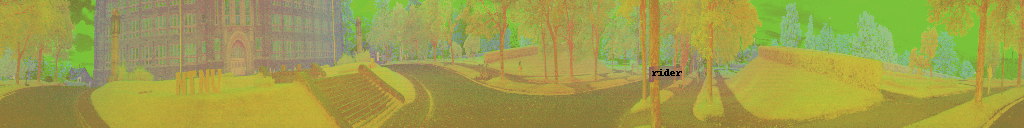

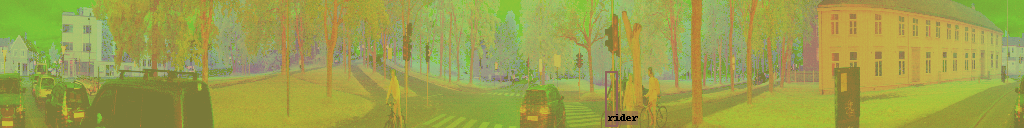

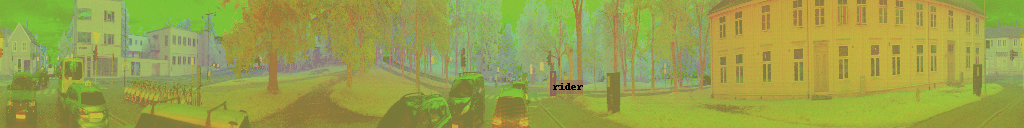

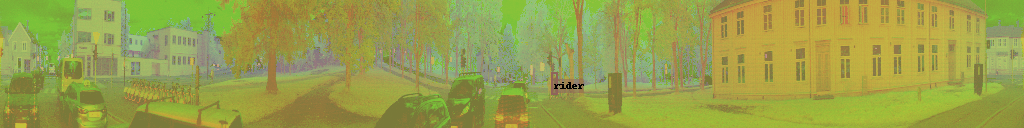

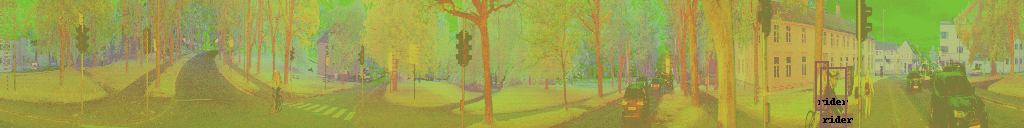

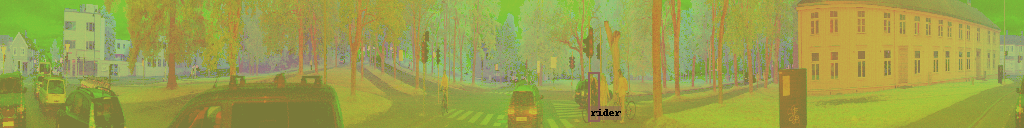

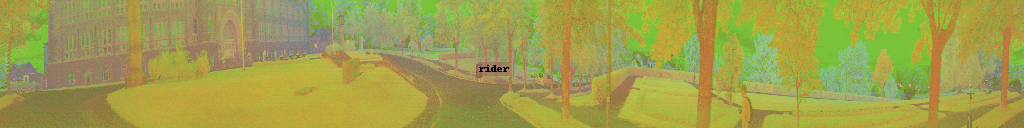

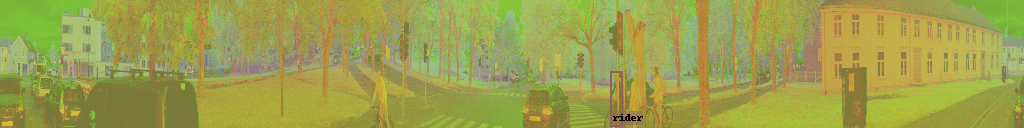

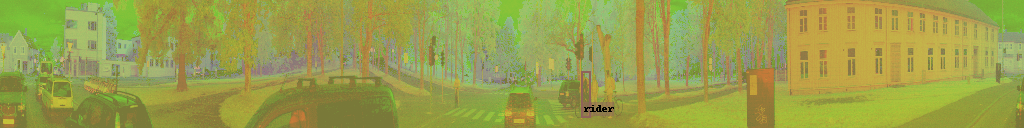

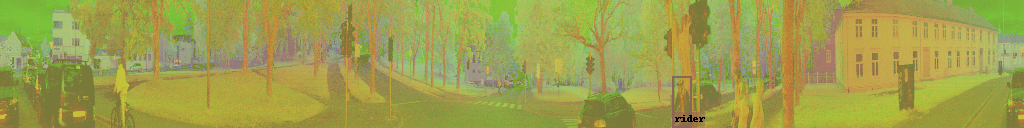

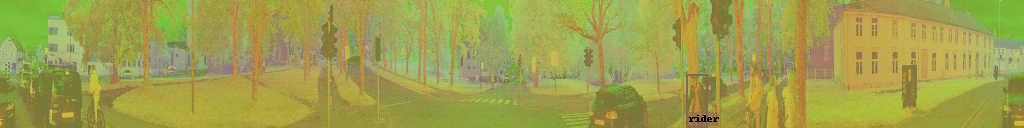

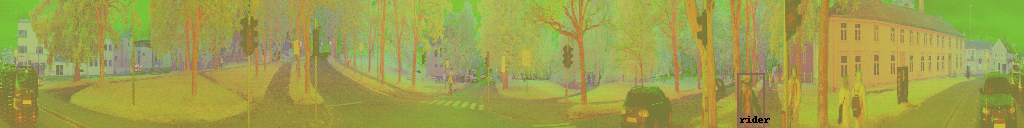

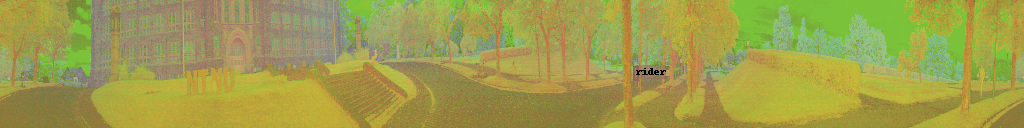

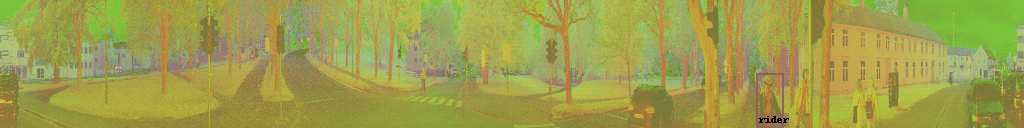

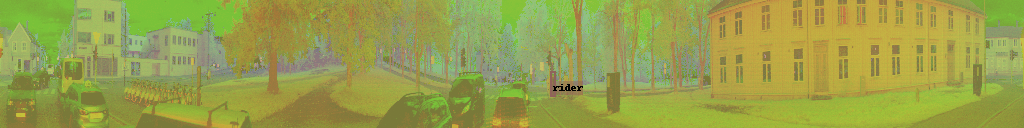

In [19]:
for i in range(20):
    file_name = os.path.join(save_dir, f"visualization_{i:04d}.png")
    Image.open(file_name).show()

In [21]:
pickle_path = os.path.join(save_dir, "viz_results.pickle")

with open(pickle_path, "wb") as f:
    pickle.dump(vizs, f)
    
with open(pickle_path, "rb") as f:
    vizs = pickle.load(f)
    
pickle_path = os.path.join(save_dir, "aspect_ratio_results.pickle")

with open(pickle_path, "wb") as f:
    pickle.dump(arcs, f)
    
with open(pickle_path, "rb") as f:
    arcs = pickle.load(f)

In [22]:
arcs

array([[ 9.20001221, 22.48999786,  7.        ],
       [60.27001953, 34.91000366,  1.        ],
       [25.63998413, 33.94999695,  1.        ],
       ...,
       [ 3.93999863, 20.78999329,  7.        ],
       [ 6.41999817, 20.15999603,  7.        ],
       [ 6.68999481, 24.58000183,  7.        ]])

In [23]:
np.unique(arcs[:,2])

array([1., 2., 3., 5., 6., 7., 8.])

In [24]:
np.max(arcs, axis=0)

array([398.79998779, 128.        ,   8.        ])

In [25]:
idx_sets = {i:np.where(arcs[:,2]==i)[0] for i in range(1,9)}

We now explore the height and weights, and thus the aspect ratio of each bounding box and their respective labels. As we mentioned earlier, arcs should hold the width and height of each bounding box as well as their class.

In [26]:
for i, sets in idx_sets.items():
    class_set = arcs[sets,:2]

    print(f"Class {i} ({cfg.label_map[i]}):")
    print("Mean:", np.mean(class_set, axis=0))
    print("Std:", np.std(class_set, axis=0))

Class 1 (car):
Mean: [28.40505191 26.05616542]
Std: [26.55110591 15.64852425]
Class 2 (truck):
Mean: [56.1479659  54.77032533]
Std: [82.57408005 40.964774  ]
Class 3 (bus):
Mean: [45.54020226 38.68278674]
Std: [78.16615369 39.74184538]
Class 4 (motorcycle):
Mean: [nan nan]
Std: [nan nan]
Class 5 (bicycle):
Mean: [13.69687465 20.63536935]
Std: [5.27880817 6.16313521]
Class 6 (scooter):
Mean: [ 9.40232592 29.63086195]
Std: [3.09765408 6.5689567 ]
Class 7 (person):
Mean: [ 7.14131151 26.73675565]
Std: [ 4.09491766 15.41474998]
Class 8 (rider):
Mean: [ 8.44787816 28.69857048]
Std: [ 4.96186613 15.2138617 ]


/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


On average, cars are quite close to a 1 aspect ratio, although there is more deviation in their width. This is to be expected given the shape of a car. This is also observed with a truck and a bus, but with a larger deviation. This may be due to cars and trucks being shaped closer to a squarewhen further away, which may make up a big portion of the examples and hence bringing the mean close to a 1 aspect ratio. For person and rider, it is expected for them to be taller than they are wide for most humans.

What is interesting is the mean for bicycle and scooters. We observe that they have higher height than width on average. To us, our mental model of a bicycle is that most of the time, it is wider than a human, yet shorter. Perhaps this is because on a road, the bicycles would be cycling along the flow of traffic and not against. Hence the "width" of a bicycle is compressed and the "height" is increase. Of course we would observe that there are bicycles crossing the road, however that would be during a traffic stop and we would only see it for that duration of a couple of seconds. Those bicycles cycling along the flow of traffic would stay in the dataset longer and hence impact the average more. 

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random

In [36]:
n = 10
colors = []

for i in range(n):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))
    
color_map = {i:colors[int(i)] for i in np.unique(arcs[:,-1])}

In [37]:
data = arcs[:, :2]
k = 8


k_means = KMeans(n_clusters=k)
k_means.fit(data)
centroids = k_means.cluster_centers_

In [38]:
centroids

array([[ 16.71368388,  51.49117493],
       [ 87.34229663,  38.67881845],
       [  9.29414873,  13.7787739 ],
       [ 44.73004442,  46.78207101],
       [324.37612718, 126.60935507],
       [  9.02475039,  31.09927413],
       [147.41641079,  70.98235047],
       [ 23.60790652,  25.87937729]])

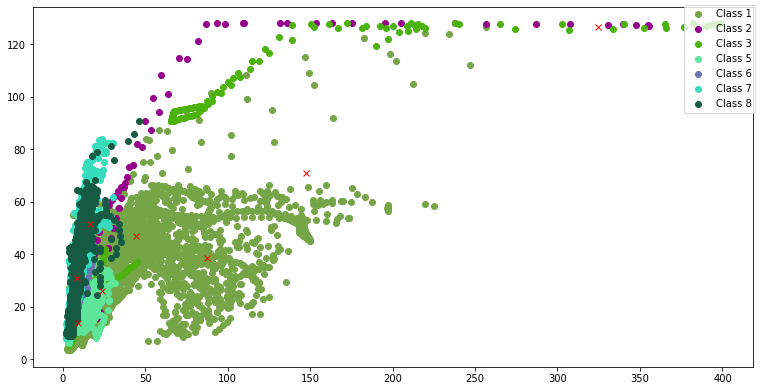

In [40]:
n_classes = np.unique(arcs[:,-1]).astype('int64')

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes((0,0,1,1))

for n_class in n_classes:
    n_class = n_class
    curr = arcs[arcs[:,-1] == n_class]
    color = color_map[n_class]
    ax.scatter(curr[:,0], curr[:,1], c=color, label=f'Class {n_class}')

for centroid in centroids:
    plt.plot(centroid[0], centroid[1], c='r', marker='x')
    
fig.legend()
fig.show()

In [84]:
centroids[:,0]/centroids[:,1]

array([0.66803553, 1.76220636, 0.8507412 , 1.69602629, 2.48290442,
       0.2885861 , 2.76400281, 0.57287838])

We feel that the clusters generated here have little meaning. We would look into visualizing the distribution of height and weight for each class and then plot a line of best fit to see on average what would be a good aspect ratio to represent that class.

Class 1	m: 0.364191600280133	c: 15.71128410854355
Class 2	m: 0.3913308217879671	c: 32.79789569133828
Class 3	m: 0.4350547645445978	c: 18.87030476818315
Class 5	m: 0.541190055800526	c: 13.222756993383394
Class 6	m: 1.128102362829836	c: 19.024075859010015
Class 7	m: 3.26774293827053	c: 3.4007853828924848
Class 8	m: 2.322968162507142	c: 9.074418469306801


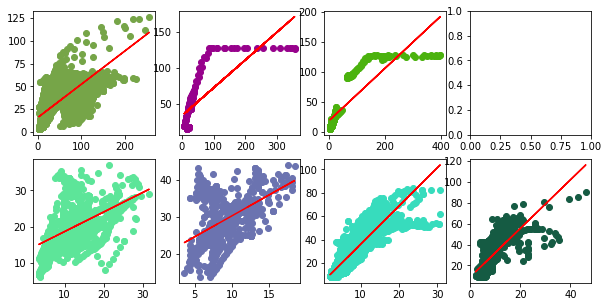

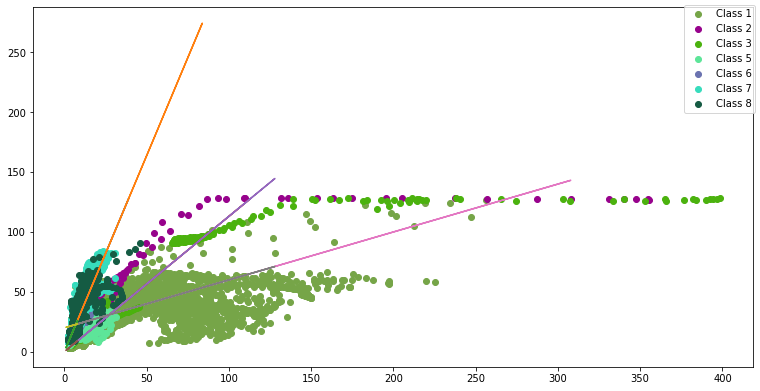

In [44]:
rows = 2
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(10,5))

n_classes = np.unique(arcs[:,-1]).astype('int64')

for n_class in n_classes:
    curr = arcs[arcs[:,-1] == n_class]
    color = color_map[n_class]
    
    row = (n_class - 1) // cols
    col = (n_class - 1) % cols
    
    X = curr[:,0]
    bestfit = np.polyfit(X, curr[:, 1], 1)
    y_line = bestfit[1] + bestfit[0] * X
    
    axes[row, col].scatter(curr[:, 0], curr[:, 1], c=color, label=f'Class {n_class}')
    axes[row, col].plot(X, y_line, 'r')
    
    print(f"Class {n_class}\tm: {bestfit[0]}\tc: {bestfit[1]}")

# axes[0,1].scatter(curr[:,0], curr[:,1])
fig.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes((0,0,1,1))

for n_class in n_classes:
    n_class = int(n_class)
    curr = arcs[arcs[:,-1] == n_class]
    color = color_map[n_class]
    ax.scatter(curr[:,0], curr[:,1], c=color, label=f'Class {n_class}')
    
t_m = 3.27
t_c = 0
    
t_x = arcs[arcs[:,0] < 128 / t_m]
t_y = t_m * t_x + t_c
plt.plot(t_x, t_y)  

t_m = 1.13
t_c = 0
    
t_x = arcs[arcs[:,0] < 128 / t_m]
t_y = t_m * t_x + t_c
plt.plot(t_x, t_y)

t_m = 0.4
t_c = 20
    
t_x = arcs[arcs[:,0] < 128 / t_m]
t_y = t_m * t_x + t_c
plt.plot(t_x, t_y)

fig.legend()
fig.show()

We also printed the gradient and intercept for each best fit line as the scaling of the axis may result in us misunderstanding the relationships across the classes. We also averaged the gradient of classes 1, 2, 3 and 5 as they have similar gradients, and ignored the gradient of class 8. We plotted these lines and it seems to be able to account for most of the relationships visually, more so than the random clusters that we generated earlier.

For further exploration, we will write a wrapper function to plot a dataset (numpy array)

In [76]:
def plot_whole_ds(ds, figsize=(10, 5)):
    n_classes = np.unique(ds[:,-1]).astype("int64")
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes((0,0,1,1))
    
    for n_class in n_classes:
        curr = ds[ds[:,-1] == n_class]
        color = color_map[n_class]
        ax.scatter(curr[:,0], curr[:,1], c=color, label=f'Class {n_class}')
        
    return fig, ax

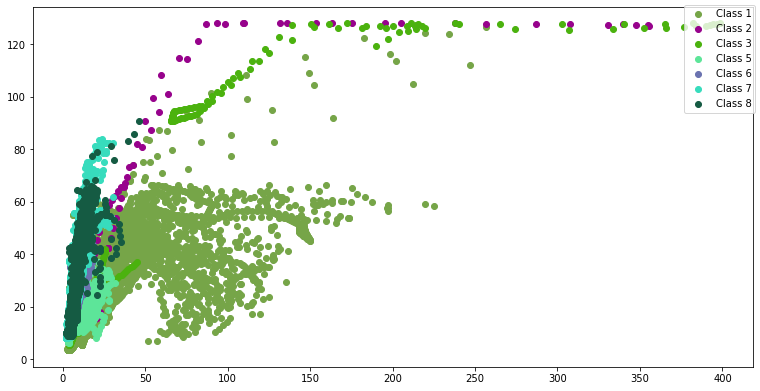

In [77]:
fig, ax = plot_whole_ds(arcs)

fig.legend()
fig.show()

With SSD, we know that there are feature maps. We hope to look at the dataset and their bounding boxes to improve the performance of the SSD. In the later task of 2.1, the feature map for the SSD is laid out. We would be using that one instead of the one in the cfg used for this task as that one is designed for an image of 300x300. This is for an image of 128x1024.

In [53]:
new_fmaps = [[32, 256], [16, 128], [8, 64], [4, 32], [2, 16], [1, 8]]
new_fmaps

[[32, 256], [16, 128], [8, 64], [4, 32], [2, 16], [1, 8]]

In [47]:
img_shape = cfg['train']['imshape']
total_area = img_shape[0] * img_shape[1]
print(total_area)

131072


In [48]:
img_shape

[128, 1024]

In [57]:
anchor_box_sizes = list(map(lambda x: [img_shape[0]//x[0], img_shape[1]//x[1]], new_fmaps))
anchor_box_sizes

[[4, 4], [8, 8], [16, 16], [32, 32], [64, 64], [128, 128]]

We decided to first multiple the height and width of each base anchor box size to get the area of the box. We then organize them into sets of upper and lower boundaries to split the dataset for the relevant feature maps.

In [122]:
fmap_areas = list(map(lambda x: x[0]*x[1], anchor_box_sizes))
fmap_areas.insert(0, 0)
fmap_areas.append(np.Inf)
fmap_areas = fmap_areas[::-1]
fmap_areas

[inf, 16384, 4096, 1024, 256, 64, 16, 0]

In [123]:
bounds = [[e, fmap_areas[i+1]] for i, e in enumerate(fmap_areas) if i+1 < len(fmap_areas)]
bounds

[[inf, 16384],
 [16384, 4096],
 [4096, 1024],
 [1024, 256],
 [256, 64],
 [64, 16],
 [16, 0]]

In [124]:
train_area = np.array(list(map(lambda x: x[0]*x[1], arcs)))

In [125]:
train_areas = np.append(train_area.reshape((-1, 1)), arcs[:,-1].reshape((-1,1)), axis=0)

In [126]:
arcs_appended = np.append(arcs, train_area.reshape((-1, 1)), axis=1)

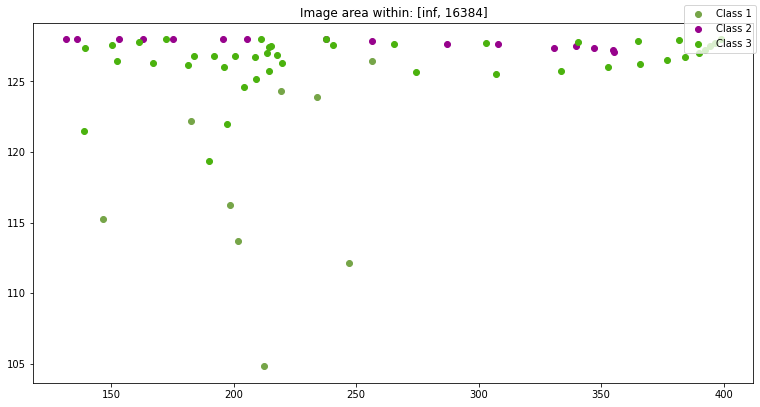

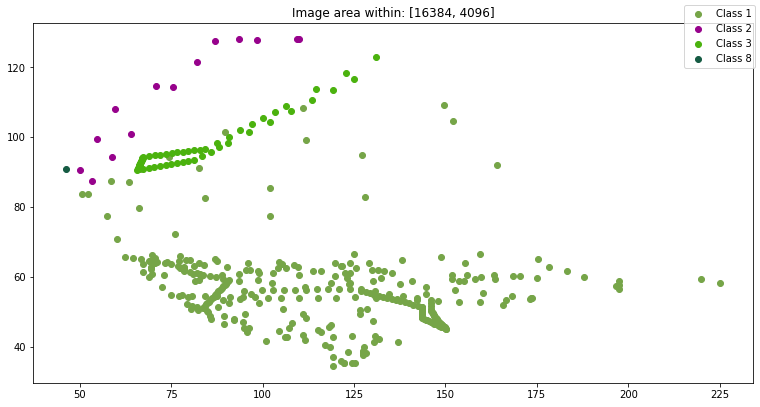

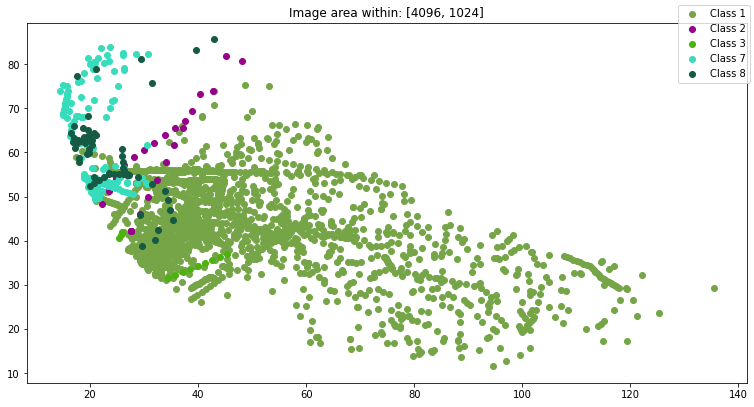

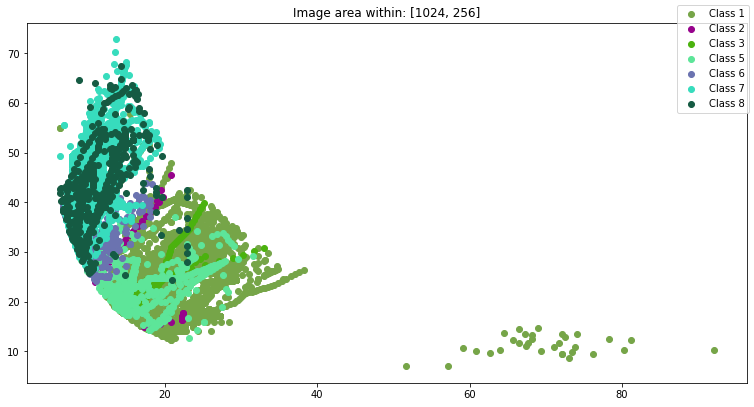

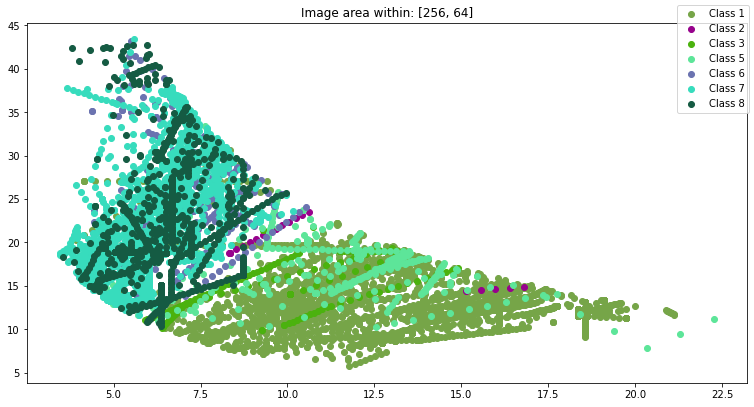

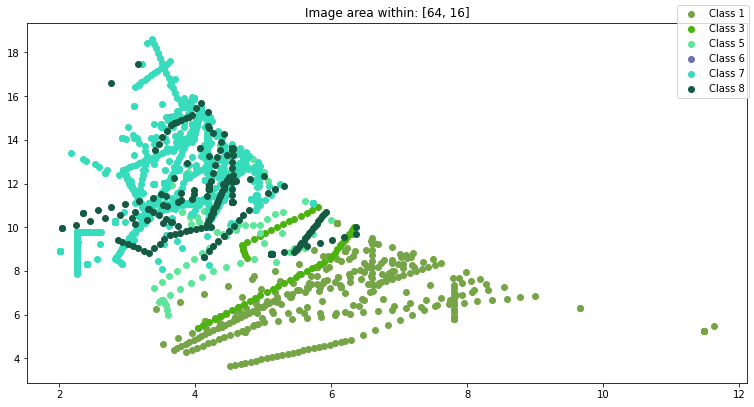

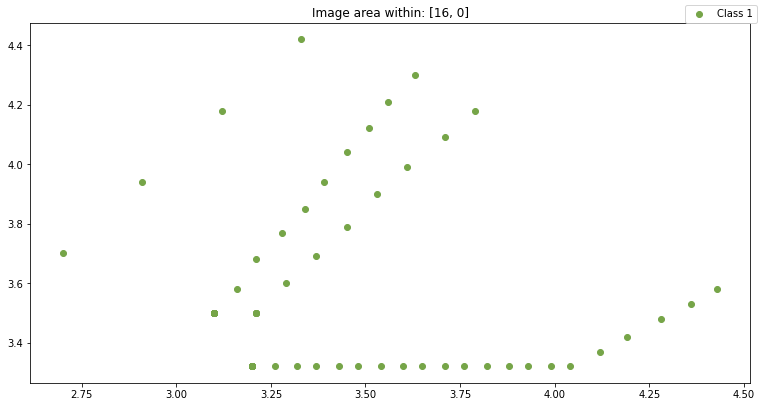

In [127]:
# figs = []
filtered_arcs = []


for bound in bounds:
    upper = bound[0]
    lower = bound[1]

    temp = arcs_appended[arcs_appended[:,-1] <= upper]
    temp = temp[temp[:,-1] > lower][:,:-1]
    filtered_arcs.append(temp)
    
    if len(temp[:, 0]) > 0:
        fig, ax = plot_whole_ds(temp)
        
        ax.set_title(f"Image area within: {bound}")
    
        fig.legend()
        fig.show()
#         figs.append(fig)

Understandably, those with the largest areas are mostly wider than they are tall. We would expect cars, trucks and buses to dominate this (which they do).

For the others except for [inf, 16384] and [4096, 1024], there seems to be generally 2 lines that guide the relationship.

We write the helper function below to help us visualize the lines that we are discussing about. However, to more precisely (and repeatably with other feature map sizes) extract the relationship, we will be using KMeans Clustering.

In [161]:
def plot_subsets_with_lines(ds, lines, y_lim=128, step=0.1):
    fig = plot_whole_ds(ds)
    
    maxes = np.max(ds, axis=0)
    x_max = maxes[0]
    
    for line in lines:
        t_m, t_c = line
        
        x_lim = (y_lim - t_c) / abs(t_m)
        num_steps = range(0, int(x_lim//step))
        x = np.array(num_steps) * step
        
        x = x[x[:] < x_max] # Filter to not draw the line past the largest x value
        
        y = t_m*x + t_c
        
        plt.plot(x, y)
        
    return fig

Aspect Ratio of Centroids: [0.50455]


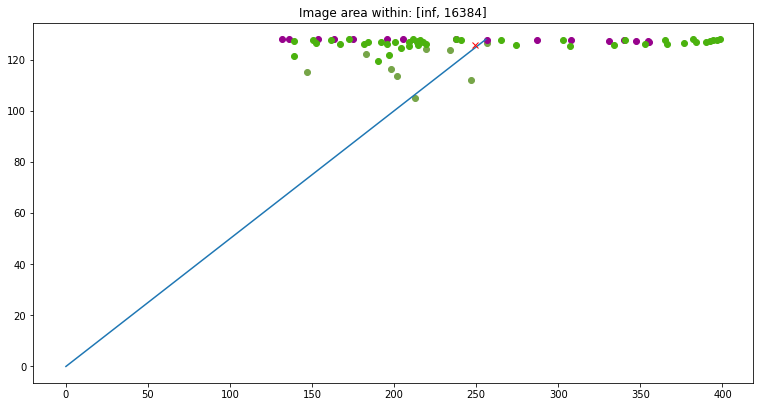

In [166]:
filter_idx = 0
n_clust = 1
dataset_target = filtered_arcs[filter_idx]


lines = [(0.5, 0)]
fig, ax = plot_subsets_with_lines(dataset_target, lines)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()

Aspect Ratio of Centroids: [0.57389]


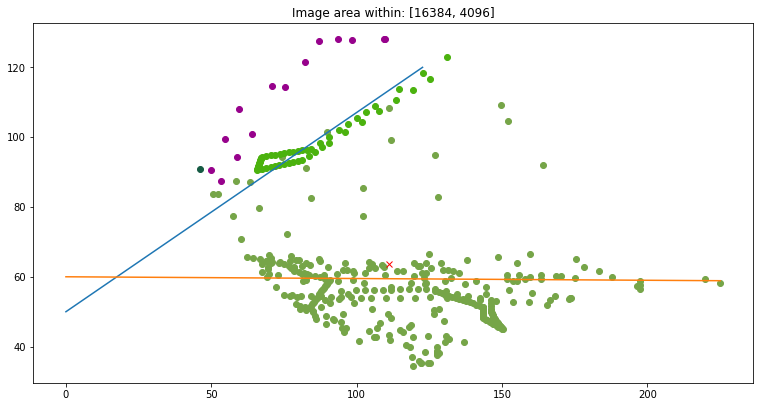

In [167]:
filter_idx = 1
y_lim = 120
n_clust = 1

dataset_target = filtered_arcs[filter_idx]

lines = [(0.57, 50), (-0.005, 60)]
fig, ax = plot_subsets_with_lines(dataset_target, lines, y_lim=y_lim)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()

Aspect Ratio of Centroids: [1.33498, 0.44906]


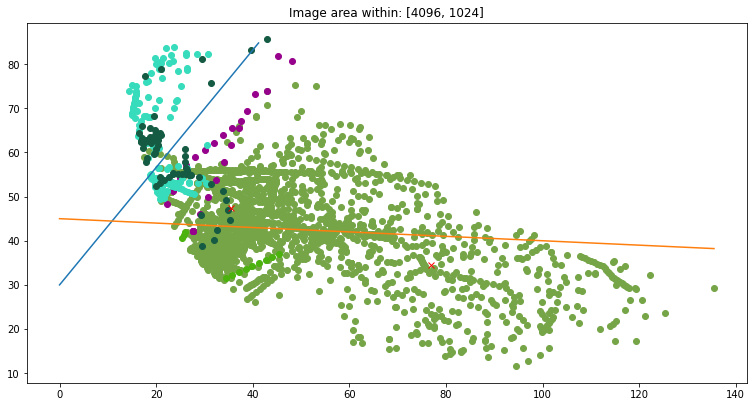

In [170]:
filter_idx = 2
y_lim = 85
n_clust = 2

dataset_target = filtered_arcs[filter_idx]

lines = [(1.33, 30), (-0.05, 45)]
fig, ax = plot_subsets_with_lines(dataset_target, lines, y_lim=y_lim)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()

Aspect Ratio of Centroids: [1.13603, 3.56149]


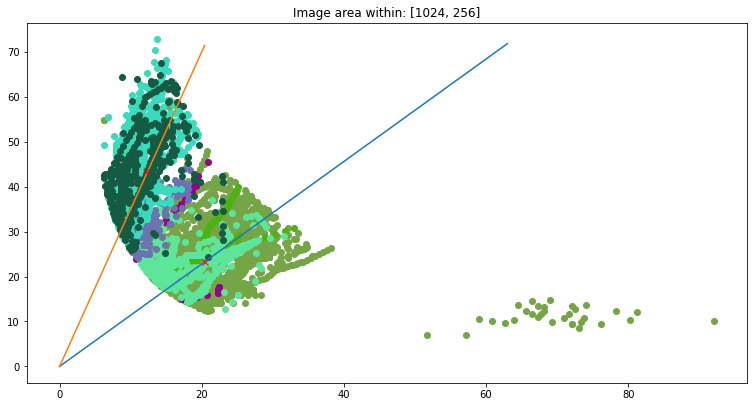

In [105]:
filter_idx = 3
y_lim = 72
n_clust = 2

dataset_target = filtered_arcs[filter_idx]

lines = [(1.14, 0), (3.5, 0)]
fig, ax = plot_subsets_with_lines(dataset_target, lines, y_lim=y_lim)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()

Aspect Ratio of Centroids: [1.17086, 3.73437]


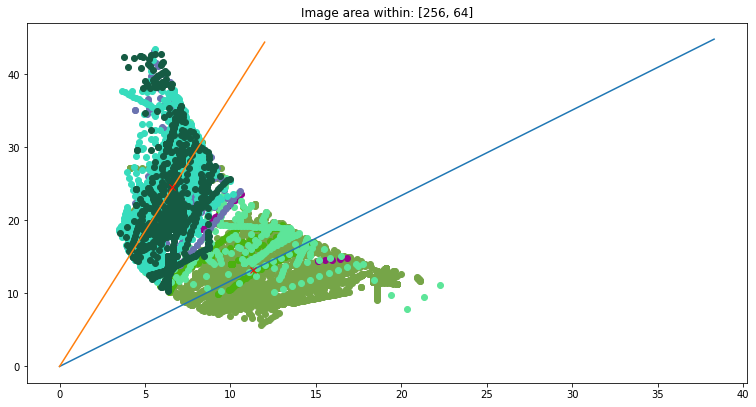

In [109]:
filter_idx = 4
y_lim = 45
n_clust = 2

dataset_target = filtered_arcs[filter_idx]

lines = [(1.17, 0), (3.7, 0)]
fig, ax = plot_subsets_with_lines(dataset_target, lines, y_lim=y_lim)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()

Aspect Ratio of Centroids: [3.2284, 1.75115]


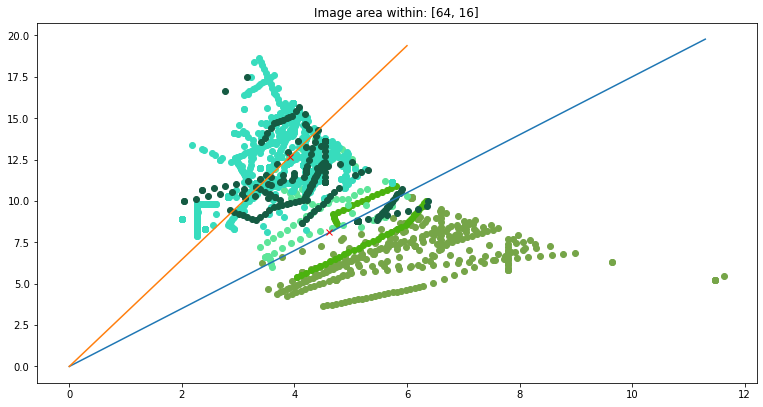

In [111]:
filter_idx = 5
y_lim = 20
n_clust = 2

dataset_target = filtered_arcs[filter_idx]

lines = [(1.75, 0), (3.23, 0)]
fig, ax = plot_subsets_with_lines(dataset_target, lines, y_lim=y_lim)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()

Aspect Ratio of Centroids: [1.11024, 0.84756]


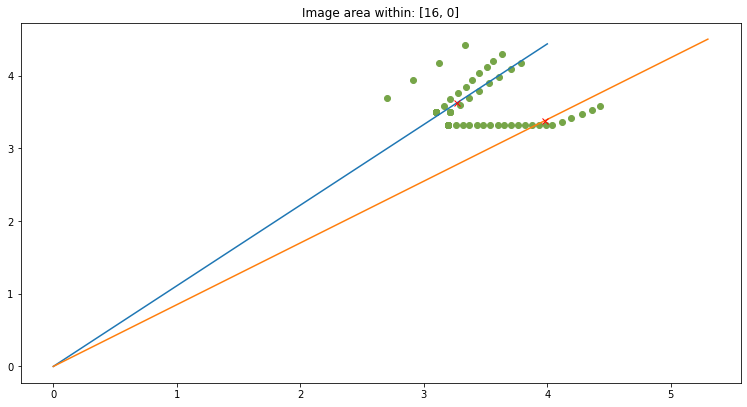

In [118]:
filter_idx = 6
y_lim = 4.6
n_clust = 2

dataset_target = filtered_arcs[filter_idx]

lines = [(1.11, 0), (0.85, 0)]
fig, ax = plot_subsets_with_lines(dataset_target, lines, y_lim=y_lim)

kmeans = KMeans(n_clust)
kmeans.fit(dataset_target[:,:-1])
print("Aspect Ratio of Centroids:", list(map(lambda x: round(x[1] / x[0], 5), kmeans.cluster_centers_)))

for point in kmeans.cluster_centers_:
    plt.plot(point[0], point[1], c='r', marker='x')
    
ax.set_title(f"Image area within: {bounds[filter_idx]}")

fig.show()